# Loss function

**Loss function**, aka cost function, measure how much the model is wrong. The goal is for it to converge toward `0`.
Which is different from it **accuracy** which measure how often it is right.

The model have been building so far is a classification model. The model on its output layer produces a probability distribution indicating which class (aka category) a given sample belong to. The predicted class is defined by `arg_max` of the probability distribution, or the class with the highest probabilty:

- the **accuracy** measures how often the `arg_max` returns the right value.
- the **loss** measures how much the model is certain about the predicted value.

Different loss functions are used depending on the type of model. In the case of linear regression, **Mean Squared Error** is used. In the case of a classification problem, the **Categorical Cross-Entropy**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Log refresher

The logarithm or log function is defined for positive number.

Bounds:

- Between 0 and 1: `[-Inifinity, 0]`
- Between 1 and +Infinity: `[0, +Infinity]`

Remarquable value: `log(1) = 0`
When omited the exposed is Euler's constant and the log function can also be refered to as natural log.


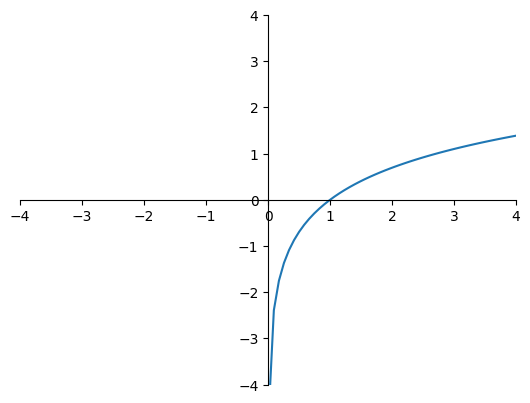

In [2]:
x = np.linspace(0.01, 4)
y = np.log(x)

fig, ax = plt.subplots()
ax.plot(x, y)

# Set plot limits
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))

# Move left y-axis and bottom x-axis to the center, passing through (0,0)
ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")

# Eliminate upper and right axes
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

plt.show()

## Categorical Cross-Entropy

Is it defined as such: `H(P, Q) = - sum(P * log(Q))`

Where:

- `H(P, Q)` is the cross entry function
- `P` is the target probability distribution
- `Q` is the approximated probability distribution

The cross-entropy function is defined from information theory. Log penalization makes it a good fit for a loss function because it penalizes more the errors.

In our case, the loss function can be greatly simplified. A sample can only belong to a single class, and therefore `P` is `1` for the target class and `0` for all the others.

`H(q) = -log(q)`

Where:

- `H` is the cross entry function
- `q` the approximated probability of the expected class


In [3]:
target = np.array([0, 1, 0])
approx = np.array([0.2, 0.7, 0.1])

loss_function = -np.log(np.sum(target * approx))
loss_function

np.float64(0.35667494393873245)

## Implementation


In [14]:
from abc import abstractmethod

import nnfs
from nnfs.datasets import spiral_data

WEIGHTS_INIT_FACTOR = 0.01


class DenseLayer:
    def __init__(self, n_inputs: int, n_neurons: int):
        self.weights = WEIGHTS_INIT_FACTOR * np.random.randn(n_inputs, n_neurons)
        self.baises = np.zeros((1, n_neurons))

    def forward(self, inputs: np.ndarray):
        self.output = np.dot(inputs, self.weights) + self.baises


class ActivationReLU:
    def forward(self, inputs: np.ndarray):
        self.output = np.maximum(inputs, 0)


class ActivationSoftMax:
    def forward(self, inputs: np.ndarray):
        norm_outputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = norm_outputs / np.sum(norm_outputs, axis=1, keepdims=True)


class Loss:
    def calculate(self, output: np.ndarray, target: np.ndarray):
        sample_losses = self.forward(output, target)
        return np.mean(sample_losses)

    @abstractmethod
    def forward(self, output: np.ndarray, target: np.ndarray) -> np.ndarray:
        pass


class LossCategoricalCrossEntropy(Loss):
    def forward(self, output: np.ndarray, target: np.ndarray) -> np.ndarray:
        # Avoid issued at the boundaries.
        clipped_predicted = np.clip(output, 1e-7, 1 - 1e-7)

        if len(target.shape) == 1:
            # Indexed target
            target_prediction = clipped_predicted[range(len(clipped_predicted)), target]
        elif len(target.shape) == 2:
            # Hot-one encoded target
            target_prediction = np.sum(clipped_predicted * target, axis=1)

        return -np.log(target_prediction)
    
def calulate_accuracy(output: np.ndarray, target: np.ndarray):
    predictions = np.argmax(output, axis=1)
    
    if len(target.shape) == 2:
        # Hot-ones encoded
        target = np.argmax(target, axis=1)
    
    # The `==` operator produce a mask where `True` -> `1` and `False` -> `0`. 
    # This is the reason why it can be calculated using mean.
    return np.mean(predictions == target)

nnfs.init()
samples, labels = spiral_data(samples=100, classes=3)

# Setup layers
layer1 = DenseLayer(n_inputs=2, n_neurons=3)
activation1 = ActivationReLU()
layer2 = DenseLayer(n_inputs=3, n_neurons=3)
activation2 = ActivationSoftMax()
loss_function = LossCategoricalCrossEntropy()

# Layer 1 forward pass
layer1.forward(samples)
activation1.forward(layer1.output)

# Layer 2 forward pass
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# Print the 5 first outputs
print(activation2.output[:5])

# Calulate loss
loss = loss_function.calculate(activation2.output, labels)
print("Loss:", loss)

accuracy = calulate_accuracy(activation2.output, labels)
print("Accuracy:", accuracy)

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
Loss: 1.0986104
Accuracy: 0.34
